# Stanford CME 241 (Winter 2026) - Assignment 2

**Due: Friday, February 13 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/EthanSei/RL-book/blob/master/Assignments/assignment2.ipynb

*Group members (replace below names with people in your group):* 
- Ethan Seide

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Ethan Seide)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

1. **State Space**: The state space of the MDP is $(i, j)$ where $i,j \in [0,n]$ represent the indices of the job. The first term is the current job the worker has (if $i = 0$ then the worker is unemployed). The second term is the current job offer the worker has when unemployed. When $i > 0$ (worker is employed) then $j = 0$.
2. **Action Space**: For unemployed states $(0,j)$, $\mathcal{A}(0,j)=\{Accept,Decline\}$. For employed states $(i,0)$ with $i>0$, there is no effective choice (both actions are equivalent).
3. **Transition Function**: For $i,j,k \in [1,n]$ and $a \in \mathcal{A}$,
  - $P((i,0)\mid(i,0),a) = 1-\alpha$
  - $P((0,k)\mid(i,0),a) = \alpha p_k$
  - $P((j,0)\mid(0,j),Accept) = 1-\alpha$
  - $P((0,k)\mid(0,j),Accept) = \alpha p_k$
  - $P((0,k)\mid(0,j),Decline) = p_k$
  - $P(s'\mid s,a)=0$ for transitions not listed above.
4. **Reward Function**: For $i,j \in [1,n]$ and $a \in \mathcal{A}$,
  - $R((i,0),a)=\log(w_i)$
  - $R((0,j),Accept)=\log(w_j)$
  - $R((0,j),Decline)=\log(w_0)$
5. Bellman Optimality Eq:

$V^{*}(s) = \max_{a\in \mathcal{A}(s)}\left[R(s,a) + \gamma \sum_{s'}\mathbb{P}(s'|s,a)V^{*}(s')\right]\\
V^{*}((i,0)) = \log(w_i) + \gamma\left((1-\alpha)V^{*}((i,0)) + \alpha\sum_k p_k V^{*}((0,k))\right),\ \forall i\in[1,n]\\
V^{*}((0,j)) = \max\left[\log(w_j) + \gamma\left((1-\alpha)V^{*}((j,0)) + \alpha\sum_k p_k V^{*}((0,k))\right),\ \log(w_0) + \gamma\sum_k p_k V^{*}((0,k))\right],\ \forall j\in[1,n]$
    

### Part (B) Answer

In [39]:
# Part (B): Value Iteration from scratch
import numpy as np

# Inputs
n: int = 5
w: list[float] = [0.5, 2, 3, 4, 12, 25]
p: list[float] = [0.0, 0.45, 0.25, 0.15, 0.1, 0.05]
alpha: float = 0.1
gamma: float = 0.97

assert len(w) == n + 1
assert len(p) == n + 1
assert np.isclose(sum(p), 1.0)
assert 0.0 <= alpha <= 1.0
assert 0.0 <= gamma < 1.0

actions: list[str] = ["Accept", "Decline"]

def build_states(n: int) -> list[tuple[int, int]]:
    unemployed_states = [(0, j) for j in range(1, n + 1)]
    employed_states = [(i, 0) for i in range(1, n + 1)]
    return unemployed_states + employed_states

def action_space(s: tuple[int, int]) -> list[str]:
    if s[0] == 0:
        return actions
    return ["Accept"]  # Equivalent to Decline in employed states

def reward(s: tuple[int, int], a: str, w: list[float]) -> float:
    i, j = s
    if i == 0:
        return np.log(w[j]) if a == "Accept" else np.log(w[0])
    return np.log(w[i])

def transition_prob(
    s: tuple[int, int],
    a: str,
    s_next: tuple[int, int],
    p: list[float],
    alpha: float
) -> float:
    i, j = s
    i_next, j_next = s_next

    if i > 0:
        if s_next == (i, 0):
            return 1 - alpha
        if i_next == 0:
            return alpha * p[j_next]
        return 0.0

    if a == "Accept":
        if s_next == (j, 0):
            return 1 - alpha
        if i_next == 0:
            return alpha * p[j_next]
        return 0.0

    if a == "Decline":
        if i_next == 0:
            return p[j_next]
        return 0.0

    raise ValueError(f"Invalid action: {a}")

def q_value(
    s: tuple[int, int],
    a: str,
    V_old: dict[tuple[int, int], float],
    states: list[tuple[int, int]],
    w: list[float],
    p: list[float],
    alpha: float,
    gamma: float
) -> float:
    continuation = sum(
        transition_prob(s, a, s_next, p, alpha) * V_old[s_next]
        for s_next in states
    )
    return reward(s, a, w) + gamma * continuation

def run_value_iteration(
    n: int,
    w: list[float],
    p: list[float],
    alpha: float,
    gamma: float,
    max_iter: int = 10_000,
    tol: float = 1e-10
) -> tuple[
    dict[tuple[int, int], float],
    dict[tuple[int, int], str],
    list[tuple[int, int]],
    int,
    float
]:
    states = build_states(n)
    V = {s: 0.0 for s in states}
    policy = {s: "Accept" for s in states}

    for it in range(1, max_iter + 1):
        V_old = V.copy()
        max_delta = 0.0

        for s in states:
            q_vals = [
                (q_value(s, a, V_old, states, w, p, alpha, gamma), a)
                for a in action_space(s)
            ]
            best_val, best_action = max(q_vals, key=lambda x: x[0])
            V[s] = best_val
            policy[s] = best_action
            max_delta = max(max_delta, abs(V[s] - V_old[s]))

        if max_delta < tol:
            return V, policy, states, it, max_delta

    return V, policy, states, max_iter, max_delta

V, policy, states, n_iters, final_delta = run_value_iteration(
    n=n,
    w=w,
    p=p,
    alpha=alpha,
    gamma=gamma
)

print(f"Converged in {n_iters} iterations (max delta = {final_delta:.2e})")
print("Optimal Value Function:")
display(V)
print("Optimal Policy:")
display(policy)

Converged in 770 iterations (max delta = 9.99e-11)
Optimal Value Function:


{(0, 1): np.float64(45.51282618187848),
 (0, 2): np.float64(45.51282618187848),
 (0, 3): np.float64(47.298359821074804),
 (0, 4): np.float64(55.94885028302847),
 (0, 5): np.float64(61.72813512617963),
 (1, 0): np.float64(41.840508005642214),
 (2, 0): np.float64(45.033146652163154),
 (3, 0): np.float64(47.298359821074804),
 (4, 0): np.float64(55.94885028302847),
 (5, 0): np.float64(61.72813512617963)}

Optimal Policy:


{(0, 1): 'Decline',
 (0, 2): 'Decline',
 (0, 3): 'Accept',
 (0, 4): 'Accept',
 (0, 5): 'Accept',
 (1, 0): 'Accept',
 (2, 0): 'Accept',
 (3, 0): 'Accept',
 (4, 0): 'Accept',
 (5, 0): 'Accept'}

### Part (C) Answer

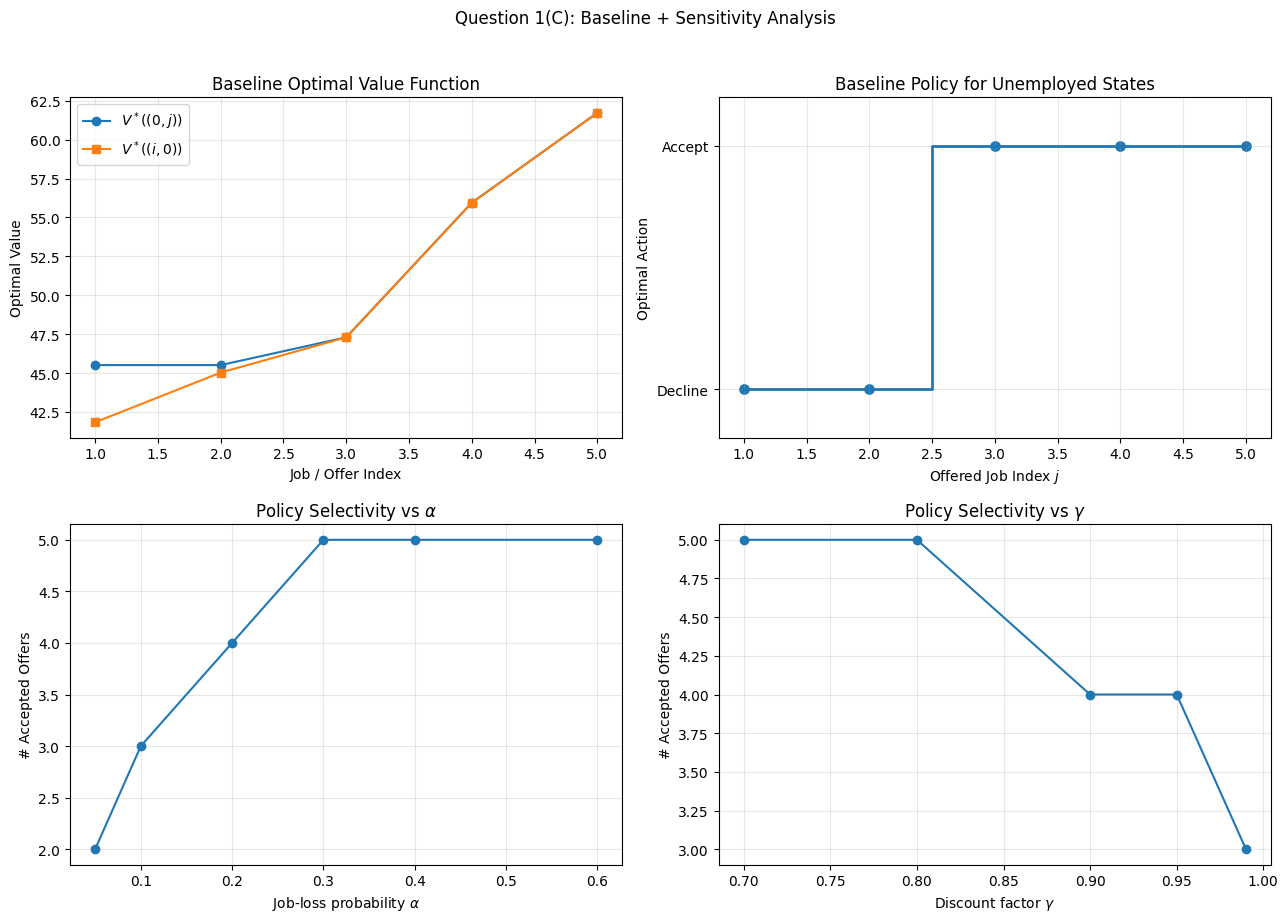

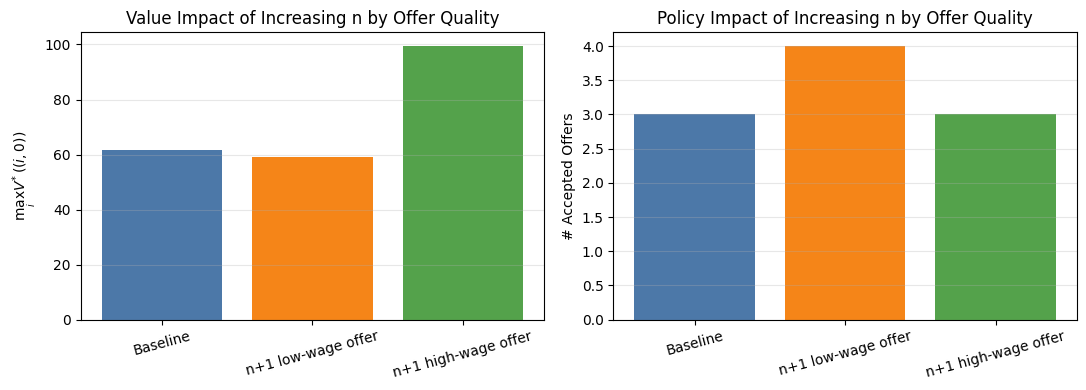

Baseline accepted offers: [3, 4, 5]
Accepted-offer counts across alpha grid: {0.05: 2, 0.1: 3, 0.2: 4, 0.3: 5, 0.4: 5, 0.6: 5}
Accepted-offer counts across gamma grid: {0.7: 5, 0.8: 5, 0.9: 4, 0.95: 4, 0.99: 3}
Accepted offers when adding low-wage offer: [2, 3, 4, 5]
Accepted offers when adding high-wage offer: [4, 5, 6]


In [40]:
# Part (C): Baseline plots + sensitivity analysis

def accepted_offers(policy_dict: dict[tuple[int, int], str], n_states: int) -> list[int]:
    return [j for j in range(1, n_states + 1) if policy_dict[(0, j)] == "Accept"]

def extend_offer_distribution(
    base_w: list[float],
    base_p: list[float],
    new_wage: float,
    new_prob: float
) -> tuple[list[float], list[float]]:
    scaled_probs = [x * (1 - new_prob) for x in base_p[1:]]
    w_ext = base_w + [new_wage]
    p_ext = [0.0] + scaled_probs + [new_prob]
    p_ext = [x / sum(p_ext) for x in p_ext]
    return w_ext, p_ext

offer_indices = list(range(1, n + 1))
unemployed_values = [V[(0, j)] for j in offer_indices]
employed_values = [V[(i, 0)] for i in offer_indices]
baseline_accept = accepted_offers(policy, n)
accept_indicator = [1 if j in baseline_accept else 0 for j in offer_indices]
baseline_max_employed = max(V[(i, 0)] for i in offer_indices)

solver_kwargs = {"max_iter": 20_000, "tol": 1e-10}

alpha_grid = [0.05, 0.10, 0.20, 0.30, 0.40, 0.60]
alpha_accept_counts = []
for alpha_test in alpha_grid:
    V_alpha, policy_alpha, _, _, _ = run_value_iteration(
        n=n, w=w, p=p, alpha=alpha_test, gamma=gamma, **solver_kwargs
    )
    accepted_alpha = accepted_offers(policy_alpha, n)
    alpha_accept_counts.append(len(accepted_alpha))

gamma_grid = [0.70, 0.80, 0.90, 0.95, 0.99]
gamma_accept_counts = []
for gamma_test in gamma_grid:
    V_gamma, policy_gamma, _, _, _ = run_value_iteration(
        n=n, w=w, p=p, alpha=alpha, gamma=gamma_test, **solver_kwargs
    )
    accepted_gamma = accepted_offers(policy_gamma, n)
    gamma_accept_counts.append(len(accepted_gamma))

# Composition experiment: same increase in n, but different new-offer quality
w_low_ext, p_low_ext = extend_offer_distribution(w, p, new_wage=1.0, new_prob=0.15)
V_low, policy_low, _, _, _ = run_value_iteration(
    n=n + 1, w=w_low_ext, p=p_low_ext, alpha=alpha, gamma=gamma, **solver_kwargs
)
low_accept = accepted_offers(policy_low, n + 1)
low_max_employed = max(V_low[(i, 0)] for i in range(1, n + 2))

w_high_ext, p_high_ext = extend_offer_distribution(w, p, new_wage=80.0, new_prob=0.15)
V_high, policy_high, _, _, _ = run_value_iteration(
    n=n + 1, w=w_high_ext, p=p_high_ext, alpha=alpha, gamma=gamma, **solver_kwargs
)
high_accept = accepted_offers(policy_high, n + 1)
high_max_employed = max(V_high[(i, 0)] for i in range(1, n + 2))

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

axes[0, 0].plot(offer_indices, unemployed_values, marker="o", label=r"$V^*((0,j))$")
axes[0, 0].plot(offer_indices, employed_values, marker="s", label=r"$V^*((i,0))$")
axes[0, 0].set_xlabel("Job / Offer Index")
axes[0, 0].set_ylabel("Optimal Value")
axes[0, 0].set_title("Baseline Optimal Value Function")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

axes[0, 1].step(offer_indices, accept_indicator, where="mid", linewidth=2)
axes[0, 1].scatter(offer_indices, accept_indicator, s=45)
axes[0, 1].set_xlabel("Offered Job Index $j$")
axes[0, 1].set_ylabel("Optimal Action")
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_yticklabels(["Decline", "Accept"])
axes[0, 1].set_ylim(-0.2, 1.2)
axes[0, 1].set_title("Baseline Policy for Unemployed States")
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(alpha_grid, alpha_accept_counts, marker="o", label="Accepted offers")
axes[1, 0].set_xlabel(r"Job-loss probability $\alpha$")
axes[1, 0].set_ylabel("# Accepted Offers")
axes[1, 0].set_title(r"Policy Selectivity vs $\alpha$")
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(gamma_grid, gamma_accept_counts, marker="o", label="Accepted offers")
axes[1, 1].set_xlabel(r"Discount factor $\gamma$")
axes[1, 1].set_ylabel("# Accepted Offers")
axes[1, 1].set_title(r"Policy Selectivity vs $\gamma$")
axes[1, 1].grid(alpha=0.3)

plt.suptitle("Question 1(C): Baseline + Sensitivity Analysis", y=1.02)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(1, 2, figsize=(11, 4))
labels = ["Baseline", "n+1 low-wage offer", "n+1 high-wage offer"]
max_employed_vals = [baseline_max_employed, low_max_employed, high_max_employed]
accept_counts = [len(baseline_accept), len(low_accept), len(high_accept)]

ax2[0].bar(labels, max_employed_vals, color=["#4C78A8", "#F58518", "#54A24B"])
ax2[0].set_ylabel(r"$\max_i V^*((i,0))$")
ax2[0].set_title("Value Impact of Increasing n by Offer Quality")
ax2[0].tick_params(axis="x", rotation=15)
ax2[0].grid(axis="y", alpha=0.3)

ax2[1].bar(labels, accept_counts, color=["#4C78A8", "#F58518", "#54A24B"])
ax2[1].set_ylabel("# Accepted Offers")
ax2[1].set_title("Policy Impact of Increasing n by Offer Quality")
ax2[1].tick_params(axis="x", rotation=15)
ax2[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Baseline accepted offers:", baseline_accept)
print("Accepted-offer counts across alpha grid:", dict(zip(alpha_grid, alpha_accept_counts)))
print("Accepted-offer counts across gamma grid:", dict(zip(gamma_grid, gamma_accept_counts)))
print("Accepted offers when adding low-wage offer:", low_accept)
print("Accepted offers when adding high-wage offer:", high_accept)

### Part (D) Answer

I observed the following patterns in the optimal policy as parameters change:

1. **$n$ alone is not enough to determine the direction of change**. The important driver is the wage-probability composition of offers. In my composition experiment (same increase from $n$ to $n+1$), adding a low-wage offer with positive probability decreased value and made the worker less selective (accepted set moved from $\{3,4,5\}$ to $\{2,3,4,5\}$), while adding a high-wage offer increased value and shifted acceptance toward top offers ($\{4,5,6\}$).
2. **As $\alpha$ increases** (jobs are less persistent), employed-state value decreases and the worker becomes less selective. In my sweep, the number of accepted offers increased from 2 to 5 as $\alpha$ moved from 0.05 to 0.60.
3. **As $\gamma$ increases** (future wages matter more), value levels increase and the worker becomes more selective. In my sweep, accepted offers dropped from 5 (at $\gamma=0.70,0.80$) to 3 (at $\gamma=0.99$), consistent with a higher reservation policy.
4. For the baseline parameters in Part (B), the unemployed policy is threshold-like in value terms: reject lower-value offers and accept only higher-value offers (here, offers $j=3,4,5$).

## Question 2: Two-Stores Inventory Control (Led by Ethan Seide)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [47]:
# Question 2: Two-Stores Inventory Control
# Refactored for readability: clear state/action definitions, capacity-feasible action set,
# and concise scenario analysis outputs.

from dataclasses import dataclass
from pathlib import Path
import sys
from typing import Dict, Mapping

import numpy as np
from scipy.stats import poisson

# Ensure the repo root (which contains `rl/`) is importable from `Assignments/`.
ROOT = Path.cwd()
if not (ROOT / "rl").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from rl.distribution import Categorical
from rl.dynamic_programming import policy_iteration_result, value_iteration_result
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.markov_process import Terminal
from rl.policy import FiniteDeterministicPolicy


# -----------------------------
# State + Action definitions
# -----------------------------
@dataclass(frozen=True)
class TwoStoreState:
    # End-of-day state before choosing actions
    # on_hand: inventory physically at store now
    # on_order: inventory already ordered previously (arrives next morning)
    s1_on_hand: int
    s1_on_order: int
    s2_on_hand: int
    s2_on_order: int

    def inventory_positions(self) -> tuple[int, int]:
        # Inventory position = on_hand + on_order
        return (
            self.s1_on_hand + self.s1_on_order,
            self.s2_on_hand + self.s2_on_order,
        )


@dataclass(frozen=True)
class TwoStoreAction:
    # New supplier orders placed now (arrive in 36 hours -> not available tomorrow)
    order_s1: int
    order_s2: int

    # Overnight transfer arriving by 6am next morning.
    # Positive => 1 -> 2, negative => 2 -> 1
    transfer_1_to_2: int


TwoStoreTransitionMap = Mapping[
    TwoStoreState,
    Mapping[TwoStoreAction, Categorical[tuple[TwoStoreState, float]]],
]


# -----------------------------
# MDP model
# -----------------------------
class TwoStoreInventoryMDP(FiniteMarkovDecisionProcess[TwoStoreState, TwoStoreAction]):
    def __init__(
        self,
        capacities: tuple[int, int],
        demand_means: tuple[float, float],
        holding_costs: tuple[float, float],
        stockout_costs: tuple[float, float],
        supplier_fixed_cost: float,
        transfer_fixed_cost: float,
    ):
        assert len(capacities) == 2
        assert len(demand_means) == 2
        assert len(holding_costs) == 2
        assert len(stockout_costs) == 2
        assert all(c >= 0 for c in capacities)
        assert all(lmbda >= 0 for lmbda in demand_means)

        self.capacities = capacities
        self.demand_means = demand_means
        self.holding_costs = holding_costs
        self.stockout_costs = stockout_costs
        self.supplier_fixed_cost = supplier_fixed_cost
        self.transfer_fixed_cost = transfer_fixed_cost

        self.poisson = (poisson(demand_means[0]), poisson(demand_means[1]))

        # Cache per-store demand outcome expansions keyed by (store_index, available_inventory)
        self._store_outcomes_cache: Dict[tuple[int, int], list[tuple[int, float, float]]] = {}

        super().__init__(self.get_action_transition_reward_map())

    def _all_states(self) -> list[TwoStoreState]:
        c1, c2 = self.capacities
        states: list[TwoStoreState] = []
        for h1 in range(c1 + 1):
            for o1 in range(c1 + 1 - h1):
                for h2 in range(c2 + 1):
                    for o2 in range(c2 + 1 - h2):
                        states.append(TwoStoreState(h1, o1, h2, o2))
        return states

    def _feasible_actions(self, state: TwoStoreState) -> list[TwoStoreAction]:
        c1, c2 = self.capacities
        ip1, ip2 = state.inventory_positions()

        # Prompt constraint: after placing new supplier orders now,
        # each store's inventory position cannot exceed capacity.
        max_order_prompt_s1 = c1 - ip1
        max_order_prompt_s2 = c2 - ip2

        # Transfer constraints: sender needs on-hand stock; receiver cannot exceed tomorrow capacity.
        max_t12 = min(state.s1_on_hand, c2 - ip2)       # max 1 -> 2
        max_t21 = min(state.s2_on_hand, c1 - ip1)       # max 2 -> 1

        actions: list[TwoStoreAction] = []

        for t12_signed in range(-max_t21, max_t12 + 1):
            send_12 = max(t12_signed, 0)
            send_21 = max(-t12_signed, 0)

            # Inventory available for next-day demand after overnight transfer.
            # (current on_order arrives overnight; new orders do NOT arrive by next morning)
            available_1 = ip1 - send_12 + send_21
            available_2 = ip2 + send_12 - send_21

            # Keep transitions within finite state space even in low-demand outcomes.
            max_order_state_s1 = c1 - available_1
            max_order_state_s2 = c2 - available_2

            max_order_s1 = min(max_order_prompt_s1, max_order_state_s1)
            max_order_s2 = min(max_order_prompt_s2, max_order_state_s2)

            for o1 in range(max_order_s1 + 1):
                for o2 in range(max_order_s2 + 1):
                    actions.append(TwoStoreAction(o1, o2, t12_signed))

        return actions

    def _single_store_outcomes(
        self,
        store_index: int,
        available_inventory: int,
    ) -> list[tuple[int, float, float]]:
        """
        Returns list of (next_on_hand, expected_stockout_penalty, probability)
        for one store, given available inventory for tomorrow.

        We enumerate demand=0..available_inventory-1 explicitly and aggregate
        all stockout events (demand >= available_inventory) into one tail event.
        """
        key = (store_index, available_inventory)
        if key in self._store_outcomes_cache:
            return self._store_outcomes_cache[key]

        distr = self.poisson[store_index]
        lam = self.demand_means[store_index]
        stockout_cost = self.stockout_costs[store_index]

        outcomes: list[tuple[int, float, float]] = []

        # No stockout outcomes
        for d in range(available_inventory):
            p = float(distr.pmf(d))
            outcomes.append((available_inventory - d, 0.0, p))

        # Stockout tail outcome
        tail_prob = float(1.0 - distr.cdf(available_inventory - 1))
        if tail_prob > 0.0:
            pmf_at_boundary = float(distr.pmf(available_inventory))
            expected_shortage_given_tail = lam - available_inventory * (
                1.0 - pmf_at_boundary / tail_prob
            )
            expected_shortage_given_tail = max(expected_shortage_given_tail, 0.0)
            tail_stockout_penalty = stockout_cost * expected_shortage_given_tail
            outcomes.append((0, tail_stockout_penalty, tail_prob))

        self._store_outcomes_cache[key] = outcomes
        return outcomes

    def get_action_transition_reward_map(self) -> TwoStoreTransitionMap:
        mapping: Dict[
            TwoStoreState,
            Dict[TwoStoreAction, Categorical[tuple[TwoStoreState, float]]],
        ] = {}

        for state in self._all_states():
            ip1, ip2 = state.inventory_positions()

            # Holding cost paid on current on-hand units.
            base_reward = (
                -self.holding_costs[0] * state.s1_on_hand
                -self.holding_costs[1] * state.s2_on_hand
            )

            action_map: Dict[TwoStoreAction, Categorical[tuple[TwoStoreState, float]]] = {}

            for action in self._feasible_actions(state):
                send_12 = max(action.transfer_1_to_2, 0)
                send_21 = max(-action.transfer_1_to_2, 0)

                available_1 = ip1 - send_12 + send_21
                available_2 = ip2 + send_12 - send_21

                fixed_cost = 0.0
                fixed_cost += self.supplier_fixed_cost * int(action.order_s1 > 0)
                fixed_cost += self.supplier_fixed_cost * int(action.order_s2 > 0)
                fixed_cost += self.transfer_fixed_cost * int(action.transfer_1_to_2 != 0)

                outcomes_s1 = self._single_store_outcomes(0, available_1)
                outcomes_s2 = self._single_store_outcomes(1, available_2)

                probs: Dict[tuple[TwoStoreState, float], float] = {}

                for next_h1, stockout_1, p1 in outcomes_s1:
                    for next_h2, stockout_2, p2 in outcomes_s2:
                        next_state = TwoStoreState(
                            s1_on_hand=next_h1,
                            s1_on_order=action.order_s1,
                            s2_on_hand=next_h2,
                            s2_on_order=action.order_s2,
                        )
                        reward = base_reward - fixed_cost - stockout_1 - stockout_2
                        probs[(next_state, reward)] = probs.get((next_state, reward), 0.0) + p1 * p2

                action_map[action] = Categorical(probs)

            mapping[state] = action_map

        return mapping


# -----------------------------
# Solve + summarize helpers
# -----------------------------
def solve_instance(
    *,
    capacities: tuple[int, int],
    demand_means: tuple[float, float],
    holding_costs: tuple[float, float],
    stockout_costs: tuple[float, float],
    supplier_fixed_cost: float,
    transfer_fixed_cost: float,
    gamma: float,
) -> tuple[
    TwoStoreInventoryMDP,
    dict[TwoStoreState, float],
    FiniteDeterministicPolicy[TwoStoreState, TwoStoreAction],
]:
    mdp = TwoStoreInventoryMDP(
        capacities=capacities,
        demand_means=demand_means,
        holding_costs=holding_costs,
        stockout_costs=stockout_costs,
        supplier_fixed_cost=supplier_fixed_cost,
        transfer_fixed_cost=transfer_fixed_cost,
    )
    vf, policy = value_iteration_result(mdp, gamma=gamma)
    vf_by_state = {s.state: v for s, v in vf.items()}
    return mdp, vf_by_state, policy


def terminal_outcome_count(mdp: TwoStoreInventoryMDP) -> int:
    # Should be 0 for a fully finite-state model.
    count = 0
    for action_map in mdp.mapping.values():
        for dist in action_map.values():
            for (s_next, _), _p in dist:
                if isinstance(s_next, Terminal):
                    count += 1
    return count


def policy_metrics(
    policy: FiniteDeterministicPolicy[TwoStoreState, TwoStoreAction],
) -> dict[str, float]:
    actions = list(policy.action_for.values())
    n = len(actions)
    transfers = [a.transfer_1_to_2 for a in actions]

    return {
        "num_states": float(n),
        "transfer_share": sum(t != 0 for t in transfers) / n,
        "avg_abs_transfer": float(np.mean([abs(t) for t in transfers])),
        "avg_signed_transfer": float(np.mean(transfers)),  # negative => net 2->1
        "avg_order_s1": float(np.mean([a.order_s1 for a in actions])),
        "avg_order_s2": float(np.mean([a.order_s2 for a in actions])),
    }


# -----------------------------
# Scenario analysis
# -----------------------------
gamma = 0.95

scenarios: dict[str, dict[str, object]] = {
    "Baseline symmetric": {
        "capacities": (5, 5),
        "demand_means": (1.4, 1.4),
        "holding_costs": (0.8, 0.8),
        "stockout_costs": (9.0, 9.0),
        "supplier_fixed_cost": 1.25,
        "transfer_fixed_cost": 1.0,
    },
    "Capacity asymmetry (C1=4, C2=2)": {
        "capacities": (8, 4),
        "demand_means": (1.6, 1.6),
        "holding_costs": (0.8, 0.8),
        "stockout_costs": (9.0, 9.0),
        "supplier_fixed_cost": 1.25,
        "transfer_fixed_cost": 1.0,
    },
    "Demand imbalance + low K2": {
        "capacities": (5, 5),
        "demand_means": (2.2, 0.8),
        "holding_costs": (0.8, 0.8),
        "stockout_costs": (9.0, 9.0),
        "supplier_fixed_cost": 1.25,
        "transfer_fixed_cost": 0.25,
    },
    "Demand imbalance + high K2": {
        "capacities": (5, 5),
        "demand_means": (2.2, 0.8),
        "holding_costs": (0.8, 0.8),
        "stockout_costs": (9.0, 9.0),
        "supplier_fixed_cost": 1.25,
        "transfer_fixed_cost": 12.0,
    },
    "Stockout asymmetry (p1 >> p2)": {
        "capacities": (5, 5),
        "demand_means": (1.6, 1.6),
        "holding_costs": (0.8, 0.8),
        "stockout_costs": (18.0, 4.0),
        "supplier_fixed_cost": 1.25,
        "transfer_fixed_cost": 1.0,
    },
}

results: dict[str, dict[str, object]] = {}

for name, params in scenarios.items():
    mdp, vf, policy = solve_instance(gamma=gamma, **params)
    metrics = policy_metrics(policy)
    results[name] = {
        "mdp": mdp,
        "vf": vf,
        "policy": policy,
        "metrics": metrics,
        "terminal_outcomes": terminal_outcome_count(mdp),
    }


def scenario_row(name: str) -> str:
    out = results[name]
    mdp = out["mdp"]
    metrics = out["metrics"]
    term = out["terminal_outcomes"]
    return (
        f"{name:33.33s} "
        f"{len(mdp.non_terminal_states):>6d} "
        f"{term:>4d} "
        f"{metrics['transfer_share']:>8.2f} "
        f"{metrics['avg_abs_transfer']:>6.2f} "
        f"{metrics['avg_order_s1']:>6.2f} "
        f"{metrics['avg_order_s2']:>6.2f} "
        f"{metrics['avg_signed_transfer']:>7.2f}"
    )


print("Scenario Summary")
print("-" * 90)
print(f"{'Scenario':33s} {'States':>6} {'Term':>4} {'TrShare':>8} {'|Tr|':>6} {'Ord1':>6} {'Ord2':>6} {'NetTr':>7}")
print("-" * 90)
for name in scenarios:
    print(scenario_row(name))

# Baseline solver consistency check: value iteration vs policy iteration
baseline_mdp = results["Baseline symmetric"]["mdp"]
baseline_vf_vi = results["Baseline symmetric"]["vf"]
baseline_policy_vi = results["Baseline symmetric"]["policy"]

baseline_vf_pi, baseline_policy_pi = policy_iteration_result(baseline_mdp, gamma=gamma)
baseline_vf_pi_by_state = {s.state: v for s, v in baseline_vf_pi.items()}

policies_match = all(
    baseline_policy_vi.action_for[s] == baseline_policy_pi.action_for[s]
    for s in baseline_policy_vi.action_for
)
max_v_gap = max(abs(baseline_vf_vi[s] - baseline_vf_pi_by_state[s]) for s in baseline_vf_vi)

print("\nSolver Check")
print("-" * 90)
print(f"Baseline VI vs PI: policies_match={policies_match}, max_value_gap={max_v_gap:.3e}")

# Prompt intuition checks
m_low_k2 = results["Demand imbalance + low K2"]["metrics"]
m_high_k2 = results["Demand imbalance + high K2"]["metrics"]
m_cap = results["Capacity asymmetry (C1=4, C2=2)"]["metrics"]
m_stockout = results["Stockout asymmetry (p1 >> p2)"]["metrics"]

print("\nIntuition Checks")
print("-" * 90)
print(
    "1) Higher K2 lowers transfer activity: "
    f"transfer_share {m_low_k2['transfer_share']:.2f} -> {m_high_k2['transfer_share']:.2f}, "
    f"avg_abs_transfer {m_low_k2['avg_abs_transfer']:.2f} -> {m_high_k2['avg_abs_transfer']:.2f}."
)
print(
    "2) With C1 > C2, store 1 carries more ordering load: "
    f"avg_order_s1={m_cap['avg_order_s1']:.2f}, avg_order_s2={m_cap['avg_order_s2']:.2f}."
)
print(
    "3) With p1 >> p2, policy protects store 1 via net 2->1 transfer: "
    f"avg_signed_transfer={m_stockout['avg_signed_transfer']:.2f}."
)


Scenario Summary
------------------------------------------------------------------------------------------
Scenario                          States Term  TrShare   |Tr|   Ord1   Ord2   NetTr
------------------------------------------------------------------------------------------
Baseline symmetric                   441    0     0.17   0.24   1.33   1.34    0.00
Capacity asymmetry (C1=4, C2=2)      675    0     0.39   0.67   1.57   0.55    0.59
Demand imbalance + low K2            441    0     0.49   0.66   1.02   1.32   -0.54
Demand imbalance + high K2           441    0     0.02   0.04   1.62   0.72   -0.04
Stockout asymmetry (p1 >> p2)        441    0     0.21   0.28   1.33   1.46   -0.26

Solver Check
------------------------------------------------------------------------------------------
Baseline VI vs PI: policies_match=True, max_value_gap=7.425e-06

Intuition Checks
------------------------------------------------------------------------------------------
1) Higher K2 lowers

### Question 2 Analysis (Clean Summary)

The code cell above answers all required parts of the prompt:

1. **Finite MDP model:** `TwoStoreInventoryMDP` is implemented as a derived class of `FiniteMarkovDecisionProcess`.
2. **Two-store parameterization:** each store has its own capacity, Poisson demand mean, holding cost, and stockout cost.
3. **Action design:** each action includes per-store supplier orders plus an overnight transfer decision between stores.
4. **Lead-time logic:**
   - existing `on_order` inventory is available for next-day demand,
   - newly placed supplier orders become next state `on_order` (36-hour delay),
   - transfer happens overnight and is available next morning.
5. **Cost structure in rewards:** holding costs + expected stockout penalties + fixed supplier-order transport cost `K_1` + fixed transfer cost `K_2`.
6. **Optimization step:** the code computes optimal value and policy with `value_iteration_result` and cross-checks baseline consistency against `policy_iteration_result`.

Key policy intuition checks from the scenario sweep:

1. **Higher transfer cost (`K_2`) reduces transfers** (both transfer frequency and transfer magnitude).
2. **Capacity asymmetry (`C_1 > C_2`) shifts replenishment toward store 1** (higher average order size at store 1).
3. **Stockout asymmetry (`p_1 \gg p_2`) causes net transfer flow from store 2 to store 1**, reflecting protection of the higher stockout-penalty location.

The finite-state construction is also validated by checking there are **no unintended terminal outcomes** in transitions.


## Question 3: Dynamic Price Optimization (Led by Ethan Seide)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer
Let $s = (t, m)$ be the state where $t \in \{0,1,\dots,T\}$ is the day index (so $T-t$ days remain) and $m \in \{0,1,\dots,M\}$ is current inventory.

If price $p_i$ is chosen, demand is $D_i \sim \mathrm{Poisson}(\lambda_i)$ with pmf $f_i(k)=\frac{e^{-\lambda_i}\lambda_i^k}{k!}$. Then for $t<T$ and $m>0$,

$$
V^*(t,m)=\max_{i\in\{1,\dots,N\}}\sum_{k=0}^{\infty} f_i(k)\left[p_i\min(k,m)+\gamma\,V^*\big(t+1,\,m-\min(k,m)\big)\right].
$$

### Part (B) Answer

The boundary states are when $t = T$ (no days remaining) or $m = 0$ (no masks in stock).

$V^*(T,m) = 0$ for all $m \in \{0,\dots,M\}$ since masks are worthless after Halloween.

$V^*(t,0) = 0$ for all $t \in \{0,\dots,T\}$ since no masks in stock means no sales.

### Part (C) Answer

V*(0, 120) = 1406.38
Optimal price at t=0 with m=120: 20.0


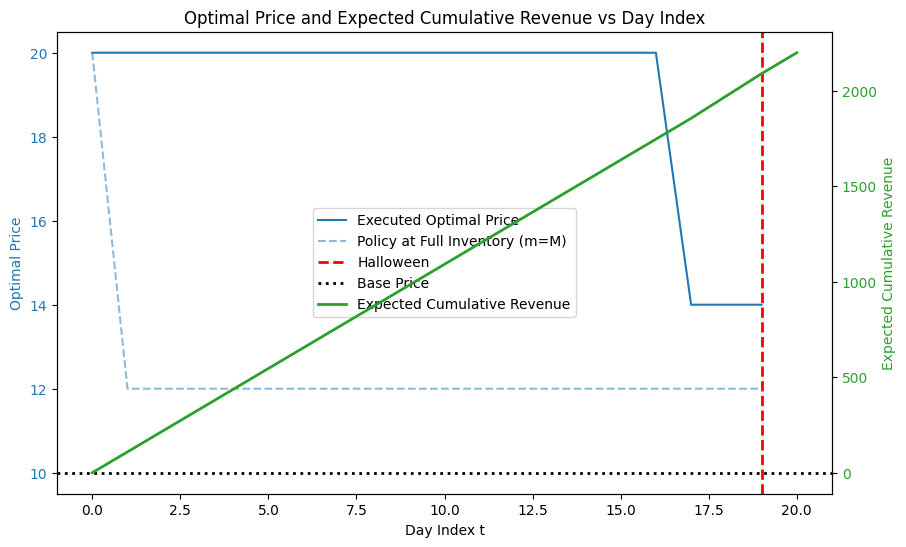

In [63]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

n = 5
p: list[float] = [10.0, 12.0, 14.0, 16.0, 20.0]
lamb: list[float] = [10.65, 10.25, 8.36, 6.35, 5.46]
gamma: float = 0.95

T: int = 20
M: int = 120

def solve_bellman(
    n: int,
    p: list[float],
    lamb: list[float],
    gamma: float,
    T: int,
    M: int,
) -> tuple[dict[tuple[int, int], float], dict[tuple[int, int], float | None]]:

    states = [(t, m) for t in range(T + 1) for m in range(M + 1)]
    V: dict[tuple[int, int], float] = {s: 0.0 for s in states}
    policy: dict[tuple[int, int], float | None] = {s: None for s in states}

    for t in range(T - 1, -1, -1):
        for m in range(1, M + 1):
            max_val = float('-inf')
            optimal_price: float | None = None

            for i in range(n):
                k_vals = np.arange(m)
                poisson_prob = poisson.pmf(k_vals, lamb[i])
                tail_prob = 1.0 - poisson.cdf(m - 1, lamb[i])

                expected_sales = float(np.dot(k_vals, poisson_prob) + m * tail_prob)
                expected_future_value = float(
                    sum(poisson_prob[k] * V[(t + 1, m - k)] for k in range(m))
                    + tail_prob * V[(t + 1, 0)]
                )

                value = p[i] * expected_sales + gamma * expected_future_value
                if value > max_val:
                    max_val = value
                    optimal_price = p[i]

            V[(t, m)] = max_val
            policy[(t, m)] = optimal_price

    return V, policy

V_star, policy = solve_bellman(n, p, lamb, gamma, T, M)

print(f"V*(0, {M}) = {V_star[(0, M)]:.2f}")
print(f"Optimal price at t=0 with m={M}: {policy[(0, M)]}")

# Approximate expected inventory and cumulative profit under optimal policy
expected_inventory = [float(M)]
expected_cumulative_profit = [0.0]
executed_price_path = []
for t in range(T):
    m_state = int(round(expected_inventory[-1]))
    m_state = max(0, min(M, m_state))
    if m_state == 0:
        executed_price_path.append(np.nan)
        expected_inventory.append(0.0)
        expected_cumulative_profit.append(expected_cumulative_profit[-1])
        continue
    chosen_price = policy[(t, m_state)]
    executed_price_path.append(chosen_price)
    i = p.index(chosen_price)
    k_vals = np.arange(m_state)
    probs = poisson.pmf(k_vals, lamb[i])
    tail_prob = 1.0 - poisson.cdf(m_state - 1, lamb[i])
    expected_sales = float(np.dot(k_vals, probs) + m_state * tail_prob)
    day_profit = chosen_price * expected_sales
    expected_inventory.append(max(0.0, expected_inventory[-1] - expected_sales))
    expected_cumulative_profit.append(expected_cumulative_profit[-1] + day_profit)

# Plot optimal policy + cumulative profit
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(range(T), executed_price_path, label='Executed Optimal Price', color='tab:blue')
ax1.plot(range(T), [policy[(t, M)] for t in range(T)], label='Policy at Full Inventory (m=M)', color='tab:blue', linestyle='--', alpha=0.5)
halloween_day = T - 1
base_price = p[0]
ax1.axvline(x=halloween_day, color='red', linestyle='--', linewidth=2, label='Halloween')
ax1.axhline(y=base_price, color='black', linestyle=':', linewidth=2, label='Base Price')
ax1.set_xlabel('Day Index t')
ax1.set_ylabel('Optimal Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(range(T + 1), expected_cumulative_profit, color='tab:green', linewidth=2, label='Expected Cumulative Revenue')
ax2.set_ylabel('Expected Cumulative Revenue', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax1.set_title('Optimal Price and Expected Cumulative Revenue vs Day Index')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
plt.show()

## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Ethan Seide)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer

Let

$$
W=(1+r)(1-\pi)+(1+R)\pi = 1+r+\pi(R-r).
$$

Because $R \sim \mathcal{N}(\mu,\sigma^2)$ and $W$ is an affine transform of $R$,

$$
W \sim \mathcal{N}(\mu_W,\sigma_W^2),\qquad
\mu_W = 1+r+\pi(\mu-r),\qquad
\sigma_W^2 = \pi^2\sigma^2.
$$

For CARA utility,

$$
U(W)=\frac{1-e^{-aW}}{a},
$$

so

$$
\mathbb{E}[U(W)] = \frac{1-\mathbb{E}[e^{-aW}]}{a}.
$$

Using the normal MGF,

$$
\mathbb{E}[e^{tW}] = \exp\!\left(t\mu_W + \frac{1}{2}t^2\sigma_W^2\right),
$$

and setting $t=-a$ gives

$$
\mathbb{E}[e^{-aW}] = \exp\!\left(-a\mu_W + \frac{a^2}{2}\sigma_W^2\right).
$$

Therefore,

$$
\mathbb{E}[U(W)]
= \frac{1}{a}\left(1-\exp\!\left[-a\mu_W+\frac{a^2}{2}\sigma_W^2\right]\right)
= \frac{1}{a}\left(1-\exp\!\left[-a\big(1+r+\pi(\mu-r)\big)+\frac{a^2}{2}\pi^2\sigma^2\right]\right).
$$

For certainty-equivalent wealth $W_{CE}$, define

$$
U(W_{CE})=\mathbb{E}[U(W)].
$$

Using a second-order Taylor approximation around $\mu_W$:

$$
\mathbb{E}[U(W)] \approx U(\mu_W)+\frac{1}{2}U''(\mu_W)\sigma_W^2,
$$

$$
U(W_{CE}) \approx U(\mu_W)+U'(\mu_W)(W_{CE}-\mu_W).
$$

Equating these,

$$
W_{CE} \approx \mu_W + \frac{1}{2}\frac{U''(\mu_W)}{U'(\mu_W)}\sigma_W^2.
$$

Since for CARA utility $\dfrac{U''(w)}{U'(w)}=-a$,

$$
W_{CE} \approx \mu_W - \frac{a}{2}\sigma_W^2
= 1+r+\pi(\mu-r)-\frac{a}{2}\pi^2\sigma^2.
$$

(Under CARA utility with normal wealth, this CE expression is also exact.)


### Part (B) Answer

Take the derivative of $\mathbb{E}[U(W)]$ with respect to $\pi$ and constrain $\pi \in [0,1]$ to determine the optimal arg max.

From Part (A):

$$
\mathbb{E}[U(W)]
= \frac{1}{a}\left(1-\exp\left[-a\left(1+r+\pi(\mu-r)\right)+\frac{a^2}{2}\pi^2\sigma^2\right]\right).
$$

Because $\exp(\cdot)$ is strictly increasing, maximizing $\mathbb{E}[U(W)]$ is equivalent to maximizing:

$$
CE(\pi)=1+r+\pi(\mu-r)-\frac{a}{2}\pi^2\sigma^2.
$$

First-order condition:

$$
\frac{dCE}{d\pi}=(\mu-r)-a\sigma^2\pi=0
\quad \Rightarrow \quad
\pi^*_{\text{unc}}=\frac{\mu-r}{a\sigma^2}.
$$

Second-order condition:

$$
\frac{d^2CE}{d\pi^2}=-a\sigma^2<0,
$$

so this is a maximum.

Unconstrained optimum:

$$
\pi^*=\frac{\mu-r}{a\sigma^2}.
$$

If the model imposes $\pi\in[0,1]$ (no shorting, no leverage), then:

$$
\pi^*=
\min\left(1,\max\left(0,\frac{\mu-r}{a\sigma^2}\right)\right).
$$


### Part (C) Answer

From Part (A):

$$
\mathbb{E}[W]=\mu_W=1+r+\pi(\mu-r),
$$

and

$$
W_{CE} \approx \mu_W-\frac{a}{2}\pi^2\sigma^2.
$$

So the absolute risk premium is

$$
\pi_A=\mathbb{E}[W]-W_{CE}
\approx \frac{a}{2}\pi^2\sigma^2.
$$

This verifies the requested result.

For CARA utility with normal wealth, this expression is actually exact (not only a small-variance approximation).


### Part (D) Answer

Given

$$
r=0.02,\quad \mu=0.08,\quad \sigma^2=0.04,\quad a=3.
$$

1. Optimal allocation:

$$
\pi^*=\frac{\mu-r}{a\sigma^2}=\frac{0.08-0.02}{3\cdot 0.04}=\frac{0.06}{0.12}=0.5.
$$

2. Certainty-equivalent wealth:

$$
\mathbb{E}[W]=1+r+\pi^*(\mu-r)=1.02+0.5(0.06)=1.05,
$$

$$
W_{CE}=\mathbb{E}[W]-\frac{a}{2}(\pi^*)^2\sigma^2
=1.05-\frac{3}{2}(0.5)^2(0.04)
=1.05-0.015
=1.035.
$$

3. Absolute risk premium:

$$
\pi_A=\mathbb{E}[W]-W_{CE}=1.05-1.035=0.015.
$$

4. Interpretation (simple):

- The investor puts 50% in the risky asset because the excess return $[(\mu-r)=0.06]$ is positive.
- Certainty-equivalent wealth is below expected wealth by 0.015, which is the cost of risk.
- If $a$ increases or $\sigma^2$ increases, then $\pi^*=\frac{\mu-r}{a\sigma^2}$ decreases, so the investor takes less risk.
- For a fixed $\pi$, risk premium $\pi_A=\frac{a}{2}\pi^2\sigma^2$ rises with both $a$ and $\sigma^2$.
- If you substitute the optimal $\pi^*$, then $\pi_A^*=\frac{(\mu-r)^2}{2a\sigma^2}$, so larger $a$ or larger $\sigma^2$ leads to a smaller chosen risk premium because the investor cuts risky exposure.


### Part (E) Answer

Now let

$$
R\sim \text{Uniform}[\alpha,\beta],
$$

and keep

$$
W=1+r+\pi(R-r)=1+r-r\pi+\pi R.
$$

Then

$$
\mathbb{E}[U(W)]
=\frac{1}{\beta-\alpha}\int_{\alpha}^{\beta}\frac{1-e^{-a(1+r-r\pi+\pi x)}}{a}\,dx.
$$

Compute the integral:

$$
\mathbb{E}[U(W)]
=\frac{1}{a}
-\frac{e^{-a(1+r-r\pi)}}{a^2\pi(\beta-\alpha)}\left(e^{-a\pi\alpha}-e^{-a\pi\beta}\right),\quad (\pi\neq 0).
$$

Equivalent expanded form:

$$
\mathbb{E}[U(W)]
=\frac{1}{a}
-\frac{e^{-a(1+r+\pi(\alpha-r))}-e^{-a(1+r+\pi(\beta-r))}}{a^2\pi(\beta-\alpha)}.
$$

Special case $\pi=0$ (all wealth in riskless asset):

$$
W=1+r \quad\Rightarrow\quad
\mathbb{E}[U(W)]=\frac{1-e^{-a(1+r)}}{a}.
$$
